In [16]:
#!sudo apt install -q tesseract-ocr
!pip install -q pytesseract

In [56]:
import pytesseract
from pytesseract import Output
import cv2
import numpy as np
from skimage import io
import matplotlib.pyplot as plt


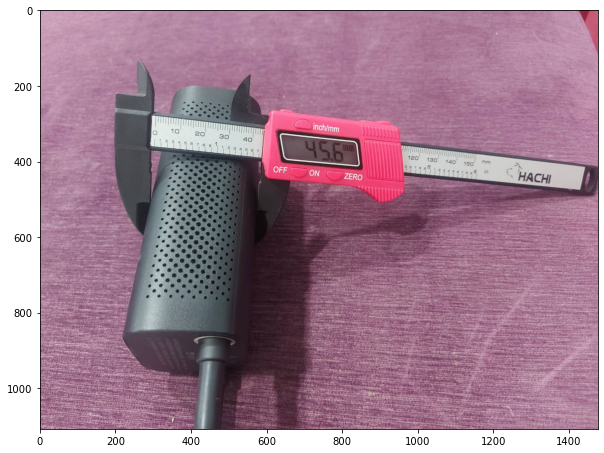

In [57]:
url = "img_vernier/626519.jpg"
img = io.imread(url)
plt.figure(figsize=(10,10))
plt.imshow(img)

# Find Histogram of Plastics

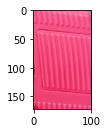

In [58]:
x = img[308:480, 852:953]
x_hsv = cv2.cvtColor(x, cv2.COLOR_RGB2HSV)

plt.subplot(2,1,1)
plt.imshow(x)
plt.subplot(2,1,1)
plt.imshow(x)

(0.0, 255.0)

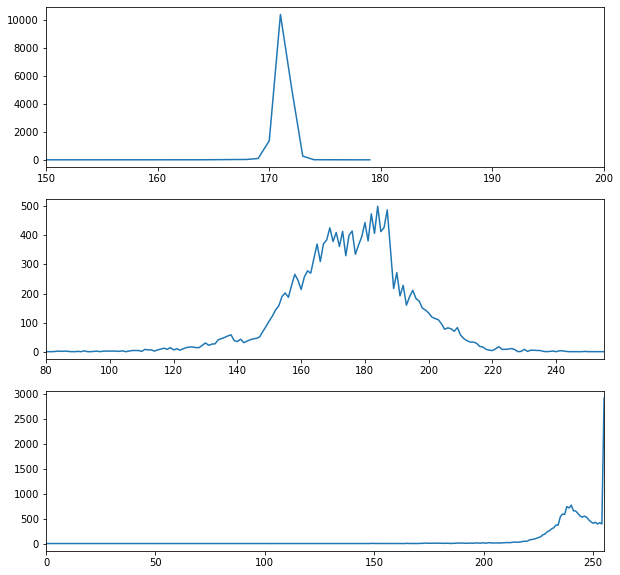

In [59]:
hist0 = cv2.calcHist([x_hsv], [0], mask = None, histSize = [180], ranges = [0, 180])
hist1 = cv2.calcHist([x_hsv], [1], mask = None, histSize = [256], ranges = [0, 256])
hist2 = cv2.calcHist([x_hsv], [2], mask = None, histSize = [256], ranges = [0, 256])

plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.plot(hist0)
plt.xlim([150, 200])
plt.subplot(3,1,2)
plt.plot(hist1)
plt.xlim([80, 255])
plt.subplot(3,1,3)
plt.plot(hist2)
plt.xlim([0, 255])


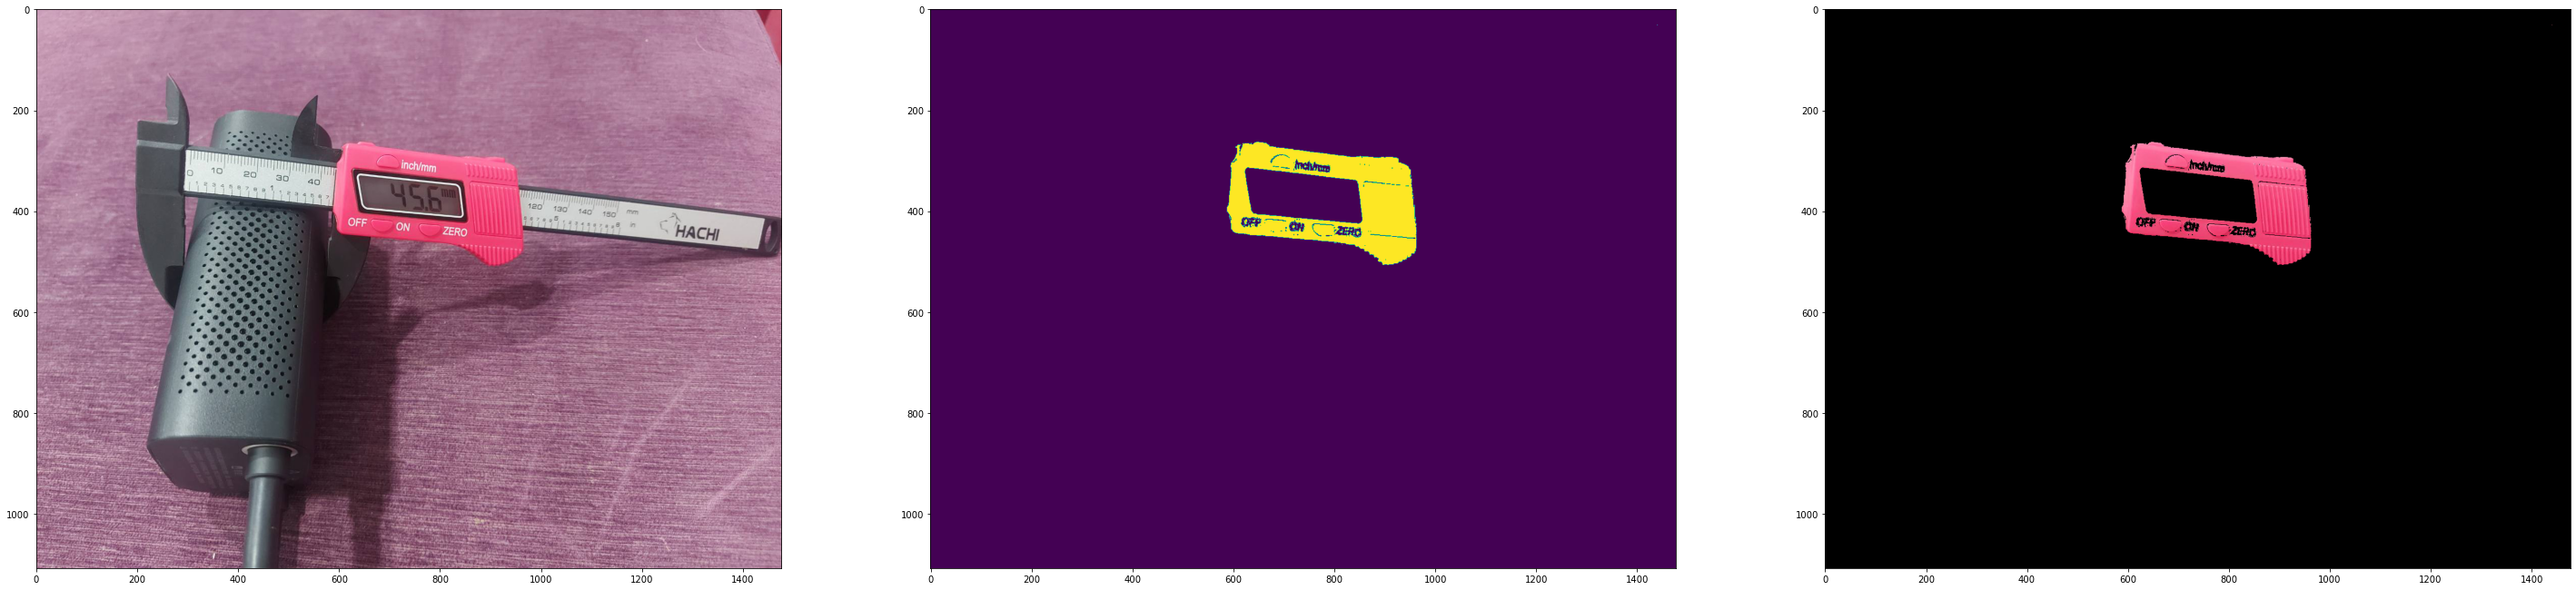

In [60]:
  
# define range of blue color in HSV
low_red = np.array([168, 100, 210], dtype=np.uint8)
high_red = np.array([175, 220,255], dtype=np.uint8)


hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

# Threshold the HSV image to get only blue colors
maskb = cv2.inRange(hsv, low_red, high_red)


# Bitwise-AND mask and original image
res = cv2.bitwise_and(img,img, mask= maskb)

plt.figure(figsize=(50,50))
plt.subplot(1,3,1)
plt.imshow(img)
plt.subplot(1,3,2)
plt.imshow(maskb)
plt.subplot(1,3,3)
plt.imshow(res)

In [61]:
def contours_filtered(contours, min_area=30,min_w=10,min_h=10):
    contours0     = []
    for cont in contours:
        x, y, w, h = cv2.boundingRect(cont)
        area = cv2.contourArea(cont)
        if min_area < area and min_w < w and  min_h < h: 
          contours0.append(cont)
    return contours0     

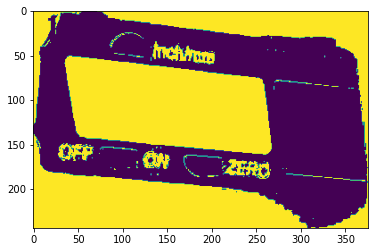

In [62]:

contour,hierarchy = cv2.findContours(maskb,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
contour          = sorted(contour, key=cv2.contourArea, reverse=False)
contour          = contours_filtered(contour, min_area=30,min_w=50,min_h=50)


x,y,w,h = cv2.boundingRect(contour[0])
mask1    = maskb[y:y+h,x:x+w]
imask1   = cv2.bitwise_not(mask1)
img1     = img[y:y+h,x:x+w]
plt.imshow( imask1)



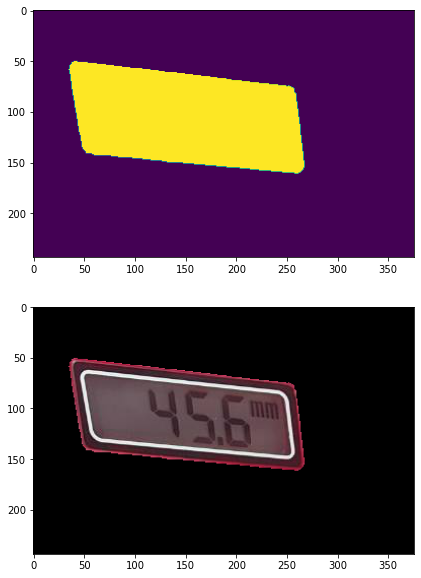

In [65]:
contour,hierarchy = cv2.findContours(imask1,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
contour          = sorted(contour, key=cv2.contourArea, reverse=False)
contour          = contours_filtered(contour, min_area=100,min_w=10,min_h= 10)

cnt             =contour[-1]
mask2           = cv2.fillPoly(np.zeros_like(imask1), pts =[cnt], color=(1))
img2            = cv2.bitwise_and(img1,img1,mask=mask2)

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.imshow(mask2)
plt.subplot(2,1,2)
plt.imshow(img2)

In [134]:
 approx = cv2.approxPolyDP(cnt, 0.01*cv2.arcLength(cnt,True),True)

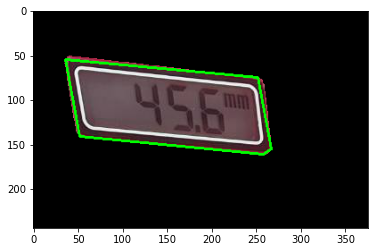

In [108]:
image = img2.copy()
image = cv2.polylines(image, [ approx ], True, (0,255,0), 2)
plt.imshow(image)                

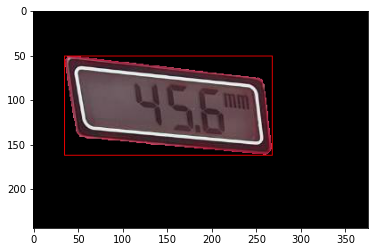

In [109]:
image = img2.copy()
x, y, w, h = cv2.boundingRect(cnt)
image = cv2.rectangle(image, (int(x),int(y)), (int(x+w),int(y+h)), (255,0,0), thickness=1)
plt.imshow(image)

In [130]:
# Cordinates of the 4 corners of the original image
points_B = np.float32([[x,y], [x+w,y], [x,y+h], [x+w,y+h]])

points_A = []

for xb in points_B :
  Ldist = [np.linalg.norm(xb-x) for x in approx ] 
  argmin = np.argmin(Ldist)
  xa     = approx[argmin].astype(np.float32)
  points_A.append(xa)
 

points_A = np.float32(points_A)

In [131]:
 
# Use the two sets of four points to compute 
# the Perspective Transformation matrix, M    
M = cv2.getPerspectiveTransform(points_A, points_B)

M

array([[ 1.00126623e+00, -1.86044339e-01,  8.90496057e+00],
       [-1.37375976e-01,  1.30696101e+00, -1.63480803e+01],
       [-3.27068460e-04,  6.76427933e-05,  1.00000000e+00]])

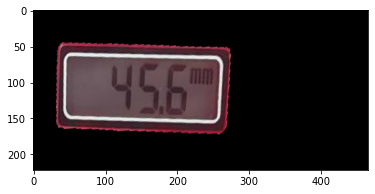

In [133]:
image = img2.copy()
warped = cv2.warpPerspective(image, M, (2*w,2*h))

plt.imshow(warped)

In [95]:
d = pytesseract.image_to_string(int(imgy[y:y+h,x:x+w]))
d

TypeError: only size-1 arrays can be converted to Python scalars